In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('train_labels.csv')
train_path = 'train/'
test_path = '/test/'
# quick look at the label stats
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [2]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

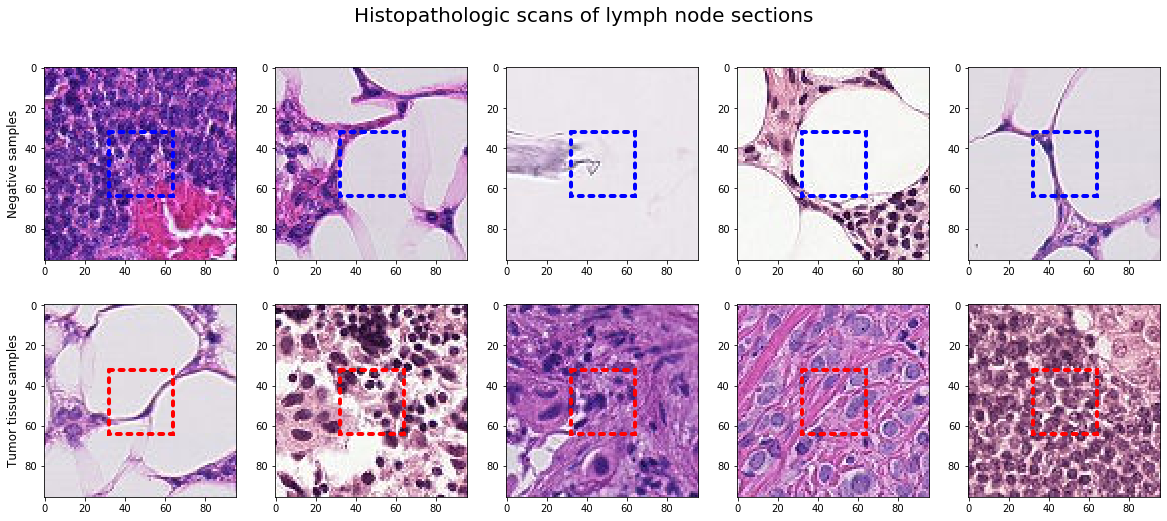

In [3]:
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [4]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

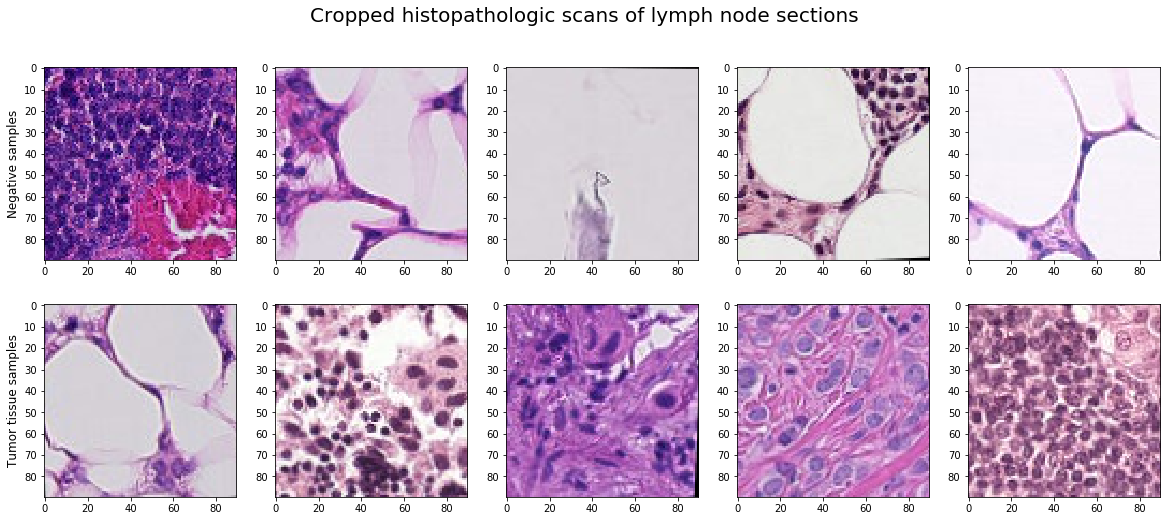

In [5]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

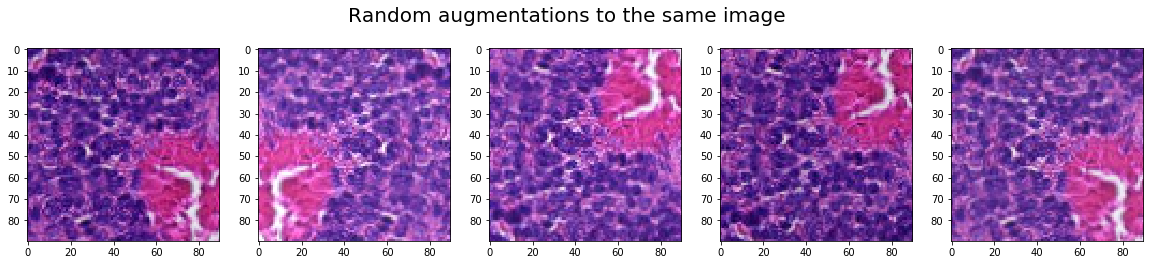

In [6]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))

In [7]:
# As we count the statistics, we can check if there are any completely black or white images
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


(array([0.70244707, 0.54624322, 0.69645334]),
 array([0.23889325, 0.28209431, 0.21625058]))

In [8]:
print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
Bright ones:
['c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '9071b424ec2e84deeb59b54d2450a6d0172cf701', '54df3640d17119486e5c5f98019d2a92736feabc', '5a268c0241b8510465cb002c4452d63fec71028a', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b']


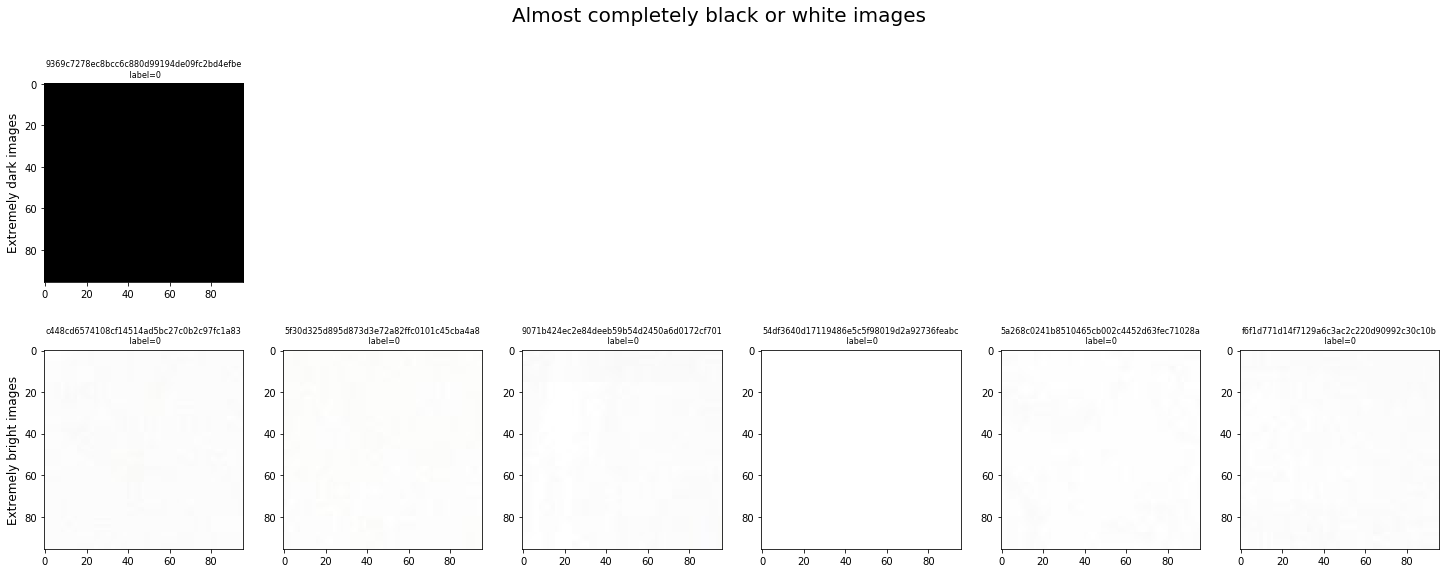

In [9]:
fig, ax = plt.subplots(2,6, figsize=(25,9))
fig.suptitle('Almost completely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(too_dark_idx)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too bright
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large')
for j in range(min(6, len(too_bright_idx)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6


In [10]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = data.set_index('id')

#If removing outliers, uncomment the four lines below
#print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
#train_df = train_df.drop(labels=too_dark_idx, axis=0)
#train_df = train_df.drop(labels=too_bright_idx, axis=0)
#print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

In [11]:
# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet169                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

In [12]:
# create dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])

In [13]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('/./','').replace('//','/'))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))

In [14]:
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        #Where to find the data?
        .split_by_idx(val_idx)
        #How to split in train/valid?
        .label_from_df(cols='label')
        #Where are the labels?
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        #dataframe pointing to the test set?
        .transform(tfms=[[],[]], size=sz)
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        .databunch(bs=BATCH_SIZE)
        # convert to databunch
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
       )

In [15]:
# dataBunch.show_batch(rows=2, figsize=(4,4))

In [16]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return create_cnn(imgDataBunch,arch,pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


In [17]:
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


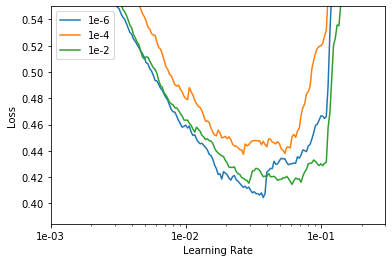

In [18]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

epoch,train_loss,valid_loss,accuracy,time
0,0.372732,0.431542,0.818343,06:35


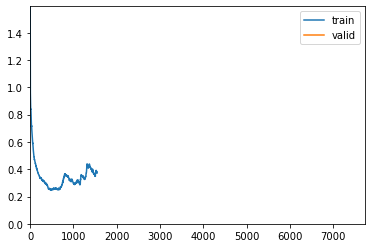

In [ ]:
max_lr = 2e-2
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=5, max_lr=max_lr, wd=wd)

In [ ]:
learner.recorder.plot_lr()

In [ ]:
learner.recorder.plot_losses()

In [ ]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [ ]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1',return_path=True)

In [ ]:
# load the baseline model
learner.load(MODEL_PATH + '_stage1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(cyc_len=6 , max_lr=slice(4e-5,4e-4))

In [ ]:
learner.export(file = 'export_clas.pkl')

In [ ]:
learner.recorder.plot_losses()

In [ ]:
# lets take a second look at the confusion matrix. See if how much we improved.
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [ ]:
# Save the finetuned model
learner.save(MODEL_PATH + '_stage2',return_path=True)

In [ ]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

In [ ]:
interp.plot_top_losses(9, figsize=(7,7))

In [ ]:
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss ',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Negative','Tumor'])

In [ ]:
interp.plot_multi_top_losses(5, figsize=(8, 8), save_misclassified=True)

In [ ]:
interp.plot_top_losses(9, figsize=(7,7),heatmap=True)

In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
# make sure we have the best performing model stage loaded
learner.load(MODEL_PATH + '_stage2')

# Fastai has a function for this but we don't want the additional augmentations it does (our image loader has augmentations) so we just use the get_preds
#preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)

# We do a fair number of iterations to cover different combinations of flips and rotations.
# The predictions are then averaged.
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

In [ ]:
# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

In [ ]:

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in tumor_preds]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['test/' + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [ ]:
df_sub.head(10)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))